In [1]:
import sys
sys.path.append('..')
import matplotlib.pyplot as plt
import numpy as np

from kernel import KernelComputer, KernelRegressor
from dataloader import Synthesizer
from regression import DF, IL, projection_il_ir, projection_df_ir

In [2]:
%matplotlib inline
np.random.seed(0)

## Toy problem

Let's imagine a toy problem, where we have to order $m$ linear forms over $X = \mathbb{R}$

In [3]:
n_train = 10
n_test = 200
exp_par, offset = 3, 1
corruption = exp_par, offset

datagen = Synthesizer('IR-' + str(n_train))
x_train, y_train = datagen.get_trainset()
x_test, y_test = datagen.get_testset(n_test)
S_train = datagen.synthetic_corruption(y_train, corruption, skewed=True)
c_train, r_train = S_train

In [4]:
def l2_loss(A, B):
    dist = A @ B.T
    dist *= -2
    dist += np.sum(A ** 2, axis=1)[:, np.newaxis]
    dist += np.sum(B ** 2, axis=1)
    return dist

In [5]:
kernel_type = 'Gaussian'  # "Laplacian"
sigmas = [5, 1, 5e-1, 1e-1, 5e-2, 1e-2]
sigmas = [1e-1]
lambdas = [1e6, 1e3, 1e0, 1e-3, 1e-6, 1e-9, 1e-12]

In [6]:
kernel = KernelComputer(kernel_type, sigma=1)
kernel_reg = KernelRegressor(kernel)
kernel_reg.set_support(x_train)

best_err_df, best_err_il, best_err_ac = 3 * (np.inf,)

for sigma in sigmas:
    kernel_reg.update_sigma(sigma)
    for lambd in lambdas:
        kernel_reg.update_lambda(lambd)
        
        alpha = kernel_reg(x_train)        
        y_dis = DF.disambiguation(alpha, S_train, 10e-6, 10e6, projection_df_ir)
        
        alpha = kernel_reg(x_test)
        alpha /= alpha.sum(axis=1)[:, np.newaxis]

        y_df = alpha @ y_dis
        y_il = IL.disambiguation(alpha, S_train, 10e-6, 10e3, projection_il_ir)
        y_ac = alpha @ c_train
        
        err_df = np.diag(l2_loss(y_df, y_test)).mean()
        err_il = np.diag(l2_loss(y_il, y_test)).mean()
        err_ac = np.diag(l2_loss(y_ac, y_test)).mean()
        
        if err_df < best_err_df:
            best_err_df = err_df
            best_y_df = y_df
            best_dis = y_dis
            best_s_df = sigma
            best_l_df = lambd
        if err_il < best_err_il:
            best_err_il = err_il
            best_y_il = y_il
            best_s_il = sigma
            best_l_il = lambd   
        if err_ac < best_err_ac:
            best_err_ac = err_ac
            best_y_ac = y_ac
            best_s_ac = sigma
            best_l_ac = lambd
        print('')

0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,
0,10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,


In [7]:
print(best_err_df, best_err_il, best_err_ac)
print(best_l_df, best_l_il, best_l_ac, best_s_df, best_s_il, best_s_ac)

0.45772926917796225 0.746401429497911 1.0497913446223173
1e-06 1.0 1.0 0.1 0.1 0.1


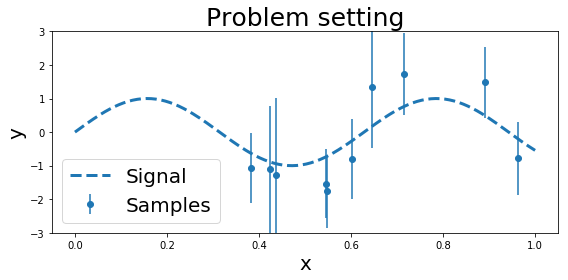

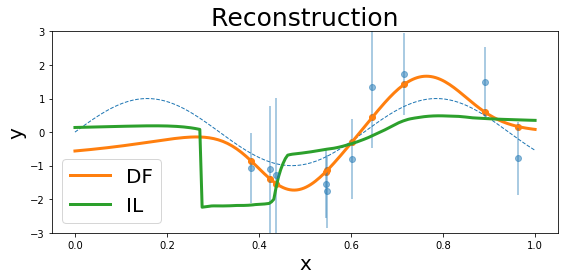

In [8]:
fig1, ax1 = plt.subplots(figsize=(8, 4))
a = ax1.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='o', color="C0")
b, = ax1.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=3, color="C0")
ax1.legend([b, a], ["Signal", "Samples"], prop={"size": 20})
ax1.set_title("Problem setting", size=25)
ax1.set_xlabel("x", size=20)
ax1.set_ylabel("y", size=20)
ax1.set_ylim(-3, 3)
fig1.tight_layout()

fig2, ax2 = plt.subplots(figsize=(8, 4))
ax2.plot(x_test.squeeze(), y_test.squeeze(), linestyle="--", linewidth=1, color="C0")
ax2.errorbar(x_train.squeeze(), c_train.squeeze(), yerr=r_train, fmt='o', color="C0", alpha=.5)
a, = ax2.plot(x_test.squeeze(), best_y_df.squeeze(), linestyle="-", linewidth=3, color="C1")
ax2.scatter(x_train.squeeze(), best_dis.squeeze(), color="C1")
b, = ax2.plot(x_test.squeeze(), best_y_il.squeeze(), linestyle="-", linewidth=3, color="C2")
# c, = ax2.plot(x_test.squeeze(), best_y_ac.squeeze(), linestyle="-", linewidth=3, color="C3")
ax2.legend([a, b], ['DF', 'IL'], prop={'size':20})
# ax2.legend([a, b, c], ['DF', 'IL', 'AC'], prop={'size':20})
ax2.set_title("Reconstruction", size=25)
ax2.set_xlabel("x", size=20)
ax2.set_ylabel("y", size=20)
ax2.set_ylim(-3, 3)
fig2.tight_layout()
# fig1.savefig('savings/ir/setting.pdf')
# fig2.savefig('savings/ir/reconstruction.pdf')